In [5]:
from astropy.io import fits
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from csaps import csaps
from scipy.ndimage import median_filter
# from astropy.stats import sigma_clip

In [6]:
import veloce_reduction_tools

In [7]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_ThAr(arm='green')

In [8]:
trace_data = np.load('veloce_trace_green.npz')
traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']

In [9]:
summing_ranges_mod = np.array([[33,29] for _ in range(len(summing_ranges))])
len(summing_ranges_mod), len(summing_ranges)

(38, 38)

In [10]:
blazes = np.load('veloce_blaze_green_pix.npz')
blazes = blazes['blazes']

In [4]:
obs_list = {'230824': ['24aug20175.fits', '24aug20176.fits', '24aug20177.fits', '24aug20178.fits', '24aug20179.fits', '24aug20180.fits', '24aug20184.fits', '24aug20185.fits', '24aug20186.fits', '24aug20187.fits', '24aug20188.fits', '24aug20189.fits', '24aug20190.fits', '24aug20191.fits', '24aug20192.fits'],
            '230826': ['26aug20146.fits', '26aug20147.fits', '26aug20148.fits', '26aug20149.fits', '26aug20150.fits', '26aug20151.fits', '26aug20152.fits', '26aug20153.fits', '26aug20154.fits', '26aug20155.fits', '26aug20156.fits', '26aug20157.fits', '26aug20158.fits', '26aug20159.fits', '26aug20160.fits', '26aug20161.fits', '26aug20162.fits', '26aug20163.fits'],
            '230828': ['28aug20153.fits', '28aug20154.fits', '28aug20155.fits', '28aug20160.fits', '28aug20161.fits', '28aug20162.fits', '28aug20163.fits', '28aug20164.fits', '28aug20165.fits', '28aug20166.fits', '28aug20167.fits', '28aug20168.fits', '28aug20169.fits', '28aug20170.fits', '28aug20171.fits', '28aug20172.fits', '28aug20173.fits', '28aug20174.fits', '28aug20175.fits'],
            '230901': ['01sep20115.fits', '01sep20116.fits', '01sep20117.fits', '01sep20118.fits', '01sep20119.fits', '01sep20120.fits', '01sep20121.fits', '01sep20122.fits'],
            '230903': ['03sep20123.fits', '03sep20124.fits', '03sep20125.fits', '03sep20126.fits', '03sep20127.fits', '03sep20128.fits', '03sep20129.fits', '03sep20130.fits', '03sep20131.fits', '03sep20132.fits', '03sep20133.fits', '03sep20134.fits', '03sep20143.fits', '03sep20144.fits', '03sep20145.fits', '03sep20146.fits', '03sep20147.fits', '03sep20148.fits']}

In [11]:
data_path = '/Volumes/chimDysk/Data/veloce/Raw/'
for date in obs_list.keys():
    for filename in obs_list[date]:
        spectrum_filename =  os.path.join(data_path, date, 'ccd_2', filename)
        image_data = fits.getdata(spectrum_filename)
        image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)
        # extracted_science_orders = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, np.array(summing_ranges, dtype=int))
        extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges_mod, remove_background=True)
        ### green part needs shift by one order issue with labeling? 
        corrected_science_orders = extracted_science_orders[1:]
        corrected_blazes = blazes[1:]

        WAVE = veloce_reduction_tools.calibrate_orders_to_wave(corrected_science_orders, Y0[0], COEFFS)
        print(filename)
        # veloce_reduction_tools.plot_order_cross_section(image_substracted_bias, traces, 50, 2)
        # plt.show()
        # plt.close()

        final_wave = []
        final_flux = []
        for wave, extracted_science_order, blaze in zip(WAVE, corrected_science_orders, corrected_blazes):
            y = np.array(blaze, dtype=np.float64)
            ysm = median_filter(y,50)
            ysm /= max(ysm)
            flux = extracted_science_order.copy()
            flux /= ysm
            flux /= np.median(flux)
            pix_max = len(wave)
            cutoff = 1000
            final_wave.append(wave[cutoff:pix_max-cutoff])
            final_flux.append(flux[cutoff:pix_max-cutoff])
        final_wave = np.array(final_wave)
        final_flux = np.array(final_flux)

        np.savez(f'veloce_green_{filename.split('.')[0]}', wave=final_wave, flux=final_flux)


24aug20175.fits
24aug20176.fits
24aug20177.fits
24aug20178.fits
24aug20179.fits
24aug20180.fits
24aug20184.fits
24aug20185.fits
24aug20186.fits
24aug20187.fits
24aug20188.fits
24aug20189.fits
24aug20190.fits
24aug20191.fits
24aug20192.fits
26aug20146.fits
26aug20147.fits
26aug20148.fits
26aug20149.fits
26aug20150.fits
26aug20151.fits
26aug20152.fits
26aug20153.fits
26aug20154.fits
26aug20155.fits
26aug20156.fits
26aug20157.fits
26aug20158.fits
26aug20159.fits
26aug20160.fits
26aug20161.fits
26aug20162.fits
26aug20163.fits
28aug20153.fits
28aug20154.fits
28aug20155.fits
28aug20160.fits
28aug20161.fits
28aug20162.fits
28aug20163.fits
28aug20164.fits
28aug20165.fits
28aug20166.fits
28aug20167.fits
28aug20168.fits
28aug20169.fits
28aug20170.fits
28aug20171.fits
28aug20172.fits
28aug20173.fits
28aug20174.fits
28aug20175.fits
01sep20115.fits
01sep20116.fits
01sep20117.fits
01sep20118.fits
01sep20119.fits
01sep20120.fits
01sep20121.fits
01sep20122.fits
03sep20123.fits
03sep20124.fits
03sep201

In [9]:
times = []
for date in obs_list.keys():
    for filename in obs_list[date]:
        spectrum_filename =  os.path.join(data_path, date, 'ccd_2', filename)
        hdul = fits.open(spectrum_filename)  # open a FITS file
        hdr = hdul[0].header
        # print(hdr['MJD-OBS'])
        times.append(hdr['MJD-OBS'])
times = np.array(times)
np.savez('HD20203_times', times)


60180.6687006
60180.6763981
60180.68408667
60180.69177505
60180.6994719
60180.70716054
60180.73674254
60180.74444002
60180.75213738
60180.75982512
60180.76753126
60180.77521877
60180.78290686
60180.79060378
60180.79829151


In [9]:
spectrum_filename =  os.path.join(os.getcwd(), 'Data', '24aug20179.fits')
image_data = fits.getdata(spectrum_filename)
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)

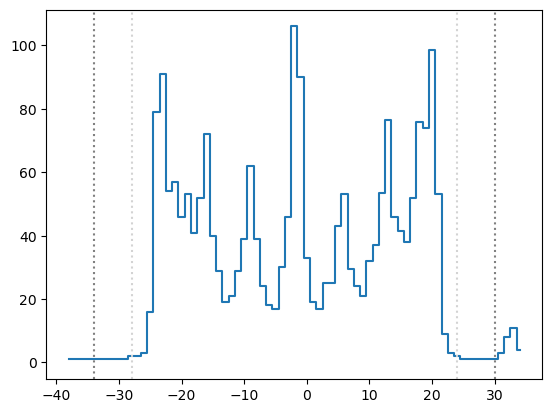

In [26]:
order = 2
veloce_reduction_tools.plot_order_cross_section(image_substracted_bias, traces, (33,29), order)
plt.show()
plt.close()

In [11]:
def plot_order_img(frame, traces, summing_range, order):
    if type(summing_range) == int:
        lower_range, upper_range = summing_range, summing_range
    elif len(summing_range) == 2:
        lower_range, upper_range = summing_range
    
    ylen, xlen = frame.shape

    trace = traces[order].copy()
    y = np.arange(ylen)
    lower_limit = min(trace)-lower_range-5
    upper_limit = max(trace)+upper_range+1

    if upper_limit > xlen:
        offset = int(np.floor(upper_limit))
        buffer = np.ones((len(y), offset))
        frame = np.concatenate((frame, buffer), axis=1)
    if lower_limit < 0:
        offset = int(-1*np.floor(lower_limit))
        # trace += offset
        buffer = np.ones((len(y), offset))
        frame = np.concatenate((buffer, frame), axis=1)
    else:
        offset = 0

    extracted_order = np.array([frame[yval, int(np.round(xval-lower_range-5, 0)+offset):int(np.round(xval+upper_range+6, 0)+offset)] 
                                            for yval, xval in zip(y, trace)])

    x = np.arange(-lower_range-5,upper_range+6)
    fig, ax = plt.subplots(1, figsize=(12,36))
    ax.imshow(extracted_order.transpose())
    plt.tight_layout()
    plt.show()
    plt.close()
    # plt.step(x,np.median(extracted_order, axis=0), where='mid')
    # plt.axline([0,-lower_range], [1,-lower_range], ls=':',c='red')
    # plt.axline([0,upper_range], [1,upper_range], ls=':',c='red')

    return extracted_order

In [10]:
summing_ranges_ind = np.array([[27, 24], #0
                               [27, 25], #1
                               [27, 25], #2 - but don't chach the zero increase padding to 5?
                               [27, 25], #2
                               [27, 25], #4
                               [27, 25], #5
                               [27, 25], #6
                               [27, 25], #7
                               [27, 25], #8
                               [27, 25], #9
                               [27, 25], #10 decrease limit on + side?
                               [27, 25], #11
                               [27, 25], #12
                               [27, 25], #13
                               [27, 25], #14
                               [27, 25], #15
                               [27, 24], #16
                               [27, 24], #17
                               [27, 24], #18
                               [27, 24], #19
                               [27, 24], #20
                               [27, 24], #21
                               [27, 24], #22
                               [26, 24], #23
                               [26, 24], #24
                               [26, 24], #25
                               [26, 24], #26
                               [26, 24], #27
                               [26, 24], #28
                               [26, 24], #29
                               [26, 24], #30
                               [26, 24], #31
                               [26, 24], #32 
                               [25, 24], #33
                               [25, 24], #34
                               [25, 24], #35
                               [25, 24], #36
                               [25, 24]]) #37


(1750.0, 1800.0)

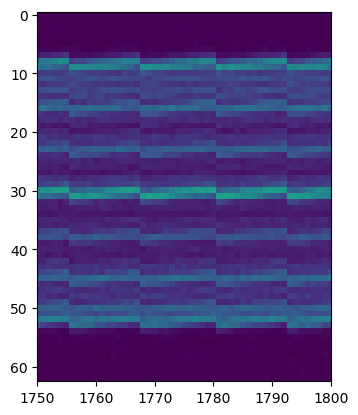

In [10]:
plt.imshow(extracted_order.transpose())
plt.xlim(1750,1800)
# plt.ylim(0,15)

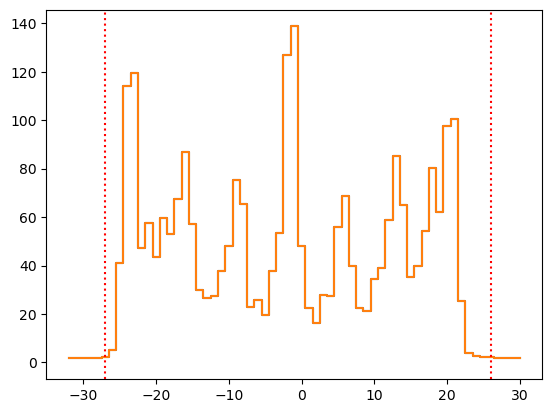

In [174]:
x = np.arange(-32,31,1)
plt.step(x,np.std(extracted_order[1000:-1000], axis=0),  where='mid')
plt.step(x,np.std(order_bkg_removed[1000:-1000], axis=0),  where='mid')
# plt.step(x,np.mean(extracted_order[1000:-1000], axis=0))
# plt.step(x,np.median(extracted_order[1000:-1000], axis=0))
plt.axline([-27,0], [-27,1], ls=':',c='red')
plt.axline([26,0], [26,1], ls=':',c='red')

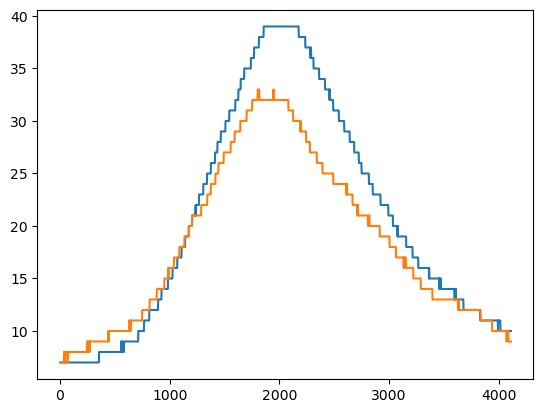

In [31]:
left, right = [], []
y = np.arange(extracted_order.shape[0])
for line in extracted_order:
    left.append(np.sum(line[:7]))
    right.append(np.sum(line[-7:]))
plt.plot(y, median_filter(left,500))
plt.plot(y, median_filter(right,500))
# plt.ylim(0,15)